# 3.1 Model Formulation

We have three variable/features in predicting whether an email is spam or not: `Contacted`, `Colleague`, and `Neither`. Since `Neither` is the base level, it is not included as a separate variable.
So,

\begin{equation}
X =  [x_1, x_2]   
\end{equation}

Logistic Regression Equation:
\begin{equation}
ln(p/1-p) =  \beta_0 + \beta_1x_1 + \beta_2x_2   
\end{equation}

where,

β₀ is the intercept

β₁ is the coefficient for emails from colleague relative to the base level `Neither`

β₂ is the coefficient for emails from contacted non-colleagues relative to the base level `Neither`

We have the following three cases:

1.   Colleague Case:
\begin{aligned}
x_1 = 1\\
x_2 = 0
\end{aligned}
then

\begin{aligned}
ln(p/1-p) =  \beta_0 + \beta_1(1) + \beta_2(0)\\
ln(p/1-p) =  \beta_0 + \beta_1
\end{aligned}


2.   Contacted Case:
\begin{aligned}
x_1 = 0\\
x_2 = 1
\end{aligned}
then

\begin{aligned}
ln(p/1-p) =  \beta_0 + \beta_1(0) + \beta_2(1)\\
ln(p/1-p) =  \beta_0 + \beta_2
\end{aligned}


3.  Neither case
\begin{aligned}
x_1 = 0\\
x_2 = 0
\end{aligned}
then

\begin{aligned}
ln(p/1-p) =  \beta_0 + \beta_1(0) + \beta_2(0)\\
ln(p/1-p) =  \beta_0
\end{aligned}

# 3.2 Calculating Coefficients

Coefficients:
\begin{equation}
\beta_0, \beta_1, \beta_2
\end{equation}

The values of the parameters can be estimated using the Log-Likelihood, which we want to maximize:


\begin{equation}
l(y, x, \beta) =  \sum_{i}^n y_ilnp_i - (1-y_i)ln(1-p_i)
\end{equation}

Since the closed form solution for the logistic regression is not possible because the likelihood equations involve nonlinear functions of the parameters, we will use the numerical method to estimate the parameters. For this case, we will use the Newton-CG (conjugate gradient), an adaption/extension of the Newton-Raphson method.

In [14]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Generate the df from the given frequency table
# since neither is base the variable, it is added implicitly, i.e., for neither both colleague and contacted will be 0
data = {
    'Colleague': [1]*11 + [1]*1829 + [0]*98 + [0]*1568 + [0]*999 + [0]*1976,
    'Contacted': [0]*11 + [0]*1829 + [1]*98 + [1]*1568 + [0]*999 + [0]*1976,
    'Spam': [1]*11 + [0]*1829 + [1]*98 + [0]*1568 + [1]*999 + [0]*1976
}
df = pd.DataFrame(data)

df['Intercept'] = 1

#columns to be used / model parameters
columns = ['Intercept', 'Colleague', 'Contacted']

X = df[columns].values
y = df['Spam'].values

def logistic_function(z):
    return 1 / (1 + np.exp(-z))

def log_likelihood(beta, X, y):
    z = np.dot(X, beta)
    return np.sum(y * np.log(logistic_function(z)) + (1 - y) * np.log(1 - logistic_function(z)))

def gradient(beta, X, y):
    z = np.dot(X, beta)
    predictions = logistic_function(z)
    return np.dot(X.T, y - predictions)

# matrix of second derivates
def hessian(beta, X, y):
    z = np.dot(X, beta)
    predictions = logistic_function(z)
    weight_matrix = predictions * (1 - predictions)
    return -np.dot(X.T, weight_matrix[:, np.newaxis] * X)

# initial parameters estimates
initial_params = np.zeros(X.shape[1])

# Optimize by maximizing the log likelihood
output = minimize(fun=lambda beta, X, y: -log_likelihood(beta, X, y),
                  x0=initial_params,
                  args=(X, y),
                  method='Newton-CG',
                  jac=lambda beta, X, y: -gradient(beta, X, y),
                  hess=lambda beta, X, y: hessian(beta, X, y))
print("\t    Coefficients:", ["Intercept", "Colleague", "Contacted"])
print("Values of the Coefficients:", output.x)

	    Coefficients: ['Intercept', 'Colleague', 'Contacted']
Values of the Coefficients: [-0.6820826  -4.43119538 -2.090507  ]


# 3.3 Implementation

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Generate the df from the given frequency table
# since neither is base the variable, it is added implicitly, i.e., for neither both colleague and contacted will be 0
data = {
    'Colleague': [1]*11 + [1]*1829 + [0]*98 + [0]*1568 + [0]*999 + [0]*1976,
    'Contacted': [0]*11 + [0]*1829 + [1]*98 + [1]*1568 + [0]*999 + [0]*1976,
    'Spam': [1]*11 + [0]*1829 + [1]*98 + [0]*1568 + [1]*999 + [0]*1976
}
df = pd.DataFrame(data)
df.head()

,Colleague,Contacted,Spam
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1


In [17]:
X = df[['Colleague', 'Contacted']]
y = df['Spam']

In [18]:
# Fit the model
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [19]:
# get the coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]
feature_names = ['Colleague', 'Contacted']
coef_df = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])
coef_df.loc['Intercept'] = intercept
print(coef_df)

           Coefficient
Colleague    -4.103004
Contacted    -2.059136
Intercept    -0.691370


There is a minor difference observed between the values of the coefficients calculated using both the methods, which can be primarily attributed to the fact that one, a different method is being used, and second, L2 regularization is being used in the sklearn implementation. As a background work, we also tried turning off the L2 regularization, which actually resulted in the values of coefficients being almost identical for both methods. Moreover, the convergence criteria for both methods can also affect the final values of the coefficients, such as the tolerance or the maximum number of iterations.

# 3.4 Confusion Matrix

In [20]:
# model prediction
y_pred = model.predict(X)

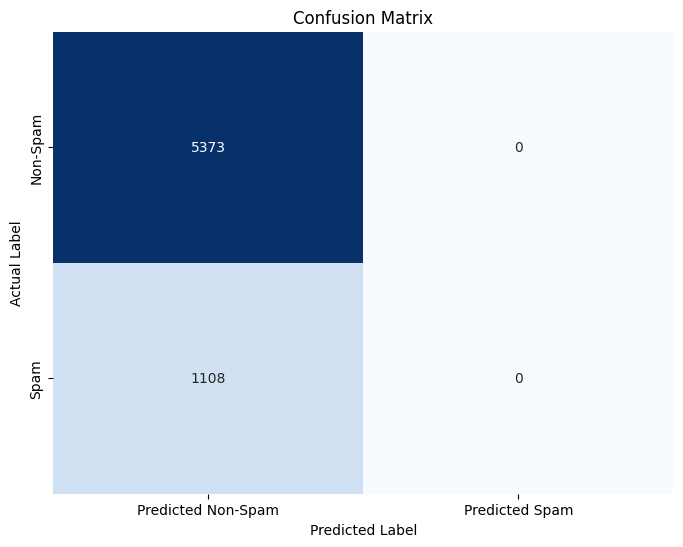

In [21]:
cm = confusion_matrix(y, y_pred)
cm_df = pd.DataFrame(cm, index=['Non-Spam', 'Spam'], columns=['Predicted Non-Spam', 'Predicted Spam'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3.5 Metrics

**Accuracy**: number of correct predictions (both true positives and true negatives) from the total predictions. A high accuracy doesn't always mean that the model is performing well. It is important to look at other metrics especially if the classes are imbalanced. We get an accuracy of around 82%, but we also have the class imbalance issue. So, this might not be representative.

\begin{equation}
Accuracy= (TP+TN+FP+FN) / (TP+TN)
\end{equation}


**Recall**: how many of the actual positives are correctly identified. Our model has a recall of 0 since it predicts the negative class (non-spam) in all the cases (TP is zero).


\begin{equation}
Recall = (TP) / (TP+FN)
\end{equation}

**Precision**: how many of the predictions are actually correct. Our model has also a precision of 0 since it predicts the negative class (non-spam) in all the cases.


\begin{equation}
Precision = (TP) / (TP+FP)
\end{equation}

**F1 Score**: The harmonic mean of Precision and Recall, providing a balance between the two in cases where one may be significantly higher than the other. 0 since precision and recall is 0.

\begin{equation}
F1 = 2(precision * recall ) / (precision+recall)
\end{equation}




In [22]:
accuracy = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred, zero_division=0)
precision = precision_score(y, y_pred, zero_division=0)
f1 = f1_score(y, y_pred, zero_division=0)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Accuracy: 0.8290387285912668
Recall: 0.0
Precision: 0.0
F1 Score: 0.0


# 3.6 Trustworthiness

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

model = LogisticRegression()
model.fit(X_res, y_res)
y_pred_res = model.predict(X_res)

accuracy_res = accuracy_score(y_res, y_pred_res)
recall_res = recall_score(y_res, y_pred_res)
precision_res = precision_score(y_res, y_pred_res)
f1_res = f1_score(y_res, y_pred_res)
print("Accuracy:", accuracy_res)
print("Recall:", recall_res)
print("Precision:", precision_res)
print("F1 Score:", f1_res)

Accuracy: 0.7700539735715615
Recall: 0.9078726968174204
Precision: 0.711701196381675
F1 Score: 0.7979062730023717


Looking at the frequency table, it can be easily observed that the data is imbalanced, i.e., around 5000 from the not-spam class and only 1100 from the spam class. This issue gets reflected in the above trained logistic regression model.

If we just look at the accuracy of the model (>80%), the model looks quite decent and trustworthy, which is quite misleading at the first sight. Upon looking into more details such as confusion matrix, it can be seen that the model is heavily biased towards the non-spam class. In fact, it classifies each sample as a non-spam, but due to the imbalance, we nevertheless get a very high accuracy.

In reality, the model is not trustworthy and fails to predict the email as spam or not. This could be because regression models rely on the mean and standard deviation. When dealing with skewed data, the mean can be deceptive as the most frequent values in the distribution might not align closely with the mean.

Moreover, the given data only checks the sender of the email, i.e., whether it has been sent by colleague, previously contacted person, or neither. It doesn't look into the content of the email, for example, use of certain words, incorrect grammar etc.


**Possible Solutions**

The model can be improved by addressing the class imbalance issue. For example, oversampling of the minority class using SMOTE (Synthetic Minority Oversampling Technique). This was done as an extra work and it can be observed that the model now performs better by not identifying all samples as non-spam. Another solution could be lowering the threshold from the default 0.5 to classify positive/negative samples. However, this could increase false positives.

**Strengths & Weaknesses**

While the approach certainly has multiple strengths like being very easy to implement and interpret, and also providing a probabilistic outcome which can be quite helpful in thresholding, it clearly lacks the complexity to provide decent results when there are issues like class imbalance. Being able to produce decent results despite class imbalance is important because in most of the practical use cases, class imbalance is present. Moreover, it can be quite prone to overfitting, as was the case in this use case.